In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers

In [3]:
IMAGE_SIZE = 50
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 615 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['0', '1']

In [6]:
len(dataset)

20

We set the batch_size 32 so all the images are stored in the batch size of 32, 

length of the dataset = total images / batch size
length of the dataset = 2152 / 32
length of the dataset = 67.25 = 68

In [7]:
for image_batch, leble_batch in dataset.take(1):
    print(image_batch[0].shape)

(50, 50, 3)


Shape of the 1st image is 256 x 256 and 3 is chennal color, which is RGB.

In [8]:
for image_batch, leble_batch in dataset.take(1):
    print(image_batch[0]) # image is in tensor, the shape is 256 x 256

tf.Tensor(
[[[221. 177. 214.]
  [213. 173. 213.]
  [201. 124. 178.]
  ...
  [208. 165. 205.]
  [207. 159. 200.]
  [197. 150. 197.]]

 [[197. 144. 191.]
  [217. 160. 206.]
  [210. 156. 198.]
  ...
  [195. 138. 189.]
  [197. 156. 201.]
  [195. 158. 199.]]

 [[198. 132. 193.]
  [206. 156. 199.]
  [214. 163. 206.]
  ...
  [204. 110. 178.]
  [201. 148. 196.]
  [201. 137. 190.]]

 ...

 [[220. 164. 205.]
  [221. 176. 212.]
  [203. 145. 198.]
  ...
  [217. 148. 196.]
  [202. 129. 189.]
  [174. 111. 173.]]

 [[205. 167. 205.]
  [242. 230. 238.]
  [207. 154. 200.]
  ...
  [219. 147. 202.]
  [197. 127. 185.]
  [209. 154. 199.]]

 [[172. 107. 169.]
  [227. 181. 216.]
  [198. 109. 172.]
  ...
  [204. 116. 180.]
  [210. 137. 193.]
  [203. 134. 190.]]], shape=(50, 50, 3), dtype=float32)


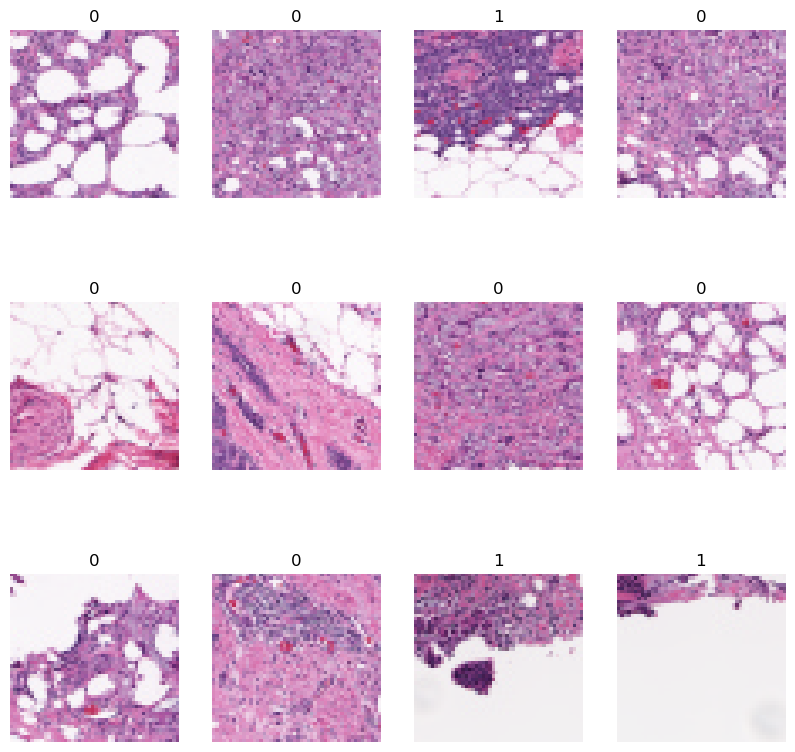

In [9]:
plt.figure(figsize=(10,10))

for image_batch, leble_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[leble_batch[i]])
        plt.axis("off")

## Splitting the data

In [10]:
EPOCH = 30

80% = training
10% = validation
10% = test

In [11]:
# Getting actual number of training data
train_size = 0.8
len(dataset) * train_size

16.0

In [12]:
# first 54 are training data
train_ds = dataset.take(54)
len(train_ds)

20

In [13]:
# Other data is for testing and validation
test_ds = dataset.skip(54)
len(test_ds)

0

In [14]:
# Splitting 10% for validation
val_size = 0.1
len(dataset) * val_size

2.0

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [16]:
# actual test dataset
test_ds = test_ds.skip(6)
len(test_ds)

0

In [17]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

len(val_ds)

In [19]:
# Optimize datasets so machine could run faster
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
# For final model we need images in 256 x 256; if user gives any image other than this dimention we need to resize it
# Creating a layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/50)
])

### Data Augmentation

In [21]:
# Creating a layer for flip and rotation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Building

In [38]:
from tensorflow.keras import layers, models

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2  # Change to 2 for binary classification

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 50, 50, 3)           0         
                                                                 
 sequential_1 (Sequential)   (32, 50, 50, 3)           0         
                                                                 
 conv2d_51 (Conv2D)          (32, 48, 48, 32)          896       
                                                                 
 max_pooling2d_51 (MaxPooli  (32, 24, 24, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (32, 22, 22, 64)          18496     
                                                                 
 max_pooling2d_52 (MaxPooli  (32, 11, 11, 64)          0         
 ng2D)                                               

In [40]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [43]:
EPOCH = 60

In [44]:
history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/60
16/16 [==============================] - 1s 34ms/step - loss: 0.2441 - accuracy: 0.9035 - val_loss: 0.4274 - val_accuracy: 0.8125
Epoch 2/60
16/16 [==============================] - 1s 35ms/step - loss: 0.2373 - accuracy: 0.9055 - val_loss: 0.3173 - val_accuracy: 0.9219
Epoch 3/60
16/16 [==============================] - 1s 33ms/step - loss: 0.2099 - accuracy: 0.9220 - val_loss: 0.2123 - val_accuracy: 0.8906
Epoch 4/60
16/16 [==============================] - 1s 38ms/step - loss: 0.2405 - accuracy: 0.9014 - val_loss: 0.2828 - val_accuracy: 0.9219
Epoch 5/60
16/16 [==============================] - 1s 33ms/step - loss: 0.2187 - accuracy: 0.9158 - val_loss: 0.1970 - val_accuracy: 0.8906
Epoch 6/60
16/16 [==============================] - 1s 33ms/step - loss: 0.2331 - accuracy: 0.9097 - val_loss: 0.2110 - val_accuracy: 0.9062
Epoch 7/60
16/16 [==============================] - 1s 34ms/step - loss: 0.2776 - accuracy: 0.8768 - val_loss: 0.2959 - val_accuracy: 0.9062
Epoch 8/60
16

In [45]:
scores = model.evaluate(test_ds)

1/2 [==============>...............] - ETA: 0s - loss: 0.0529 - accuracy: 1.0000

2/2 [==============================] - 0s 13ms/step - loss: 0.0951 - accuracy: 0.9487


In [46]:
history

In [47]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 16}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
len(history.history['accuracy'])

60

In [50]:
# storing params for plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

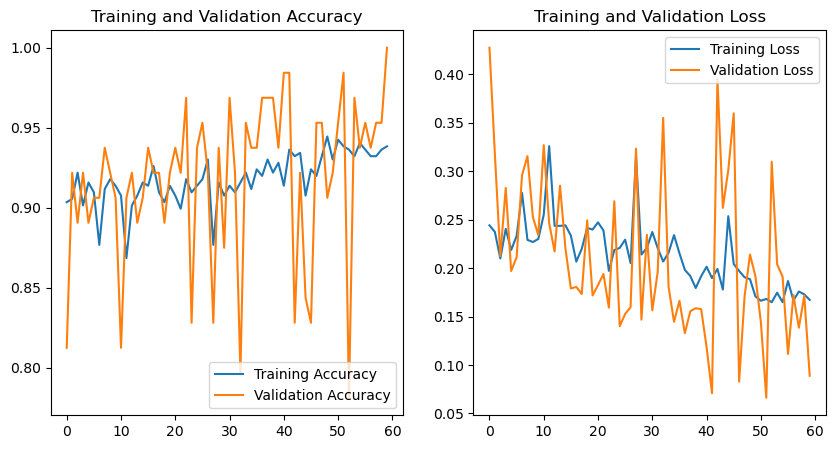

In [51]:
# Plotting the params

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(EPOCH), acc, label = "Training Accuracy")
plt.plot(range(EPOCH), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCH), loss, label = "Training Loss")
plt.plot(range(EPOCH), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")

plt.show()

### Prediction

First image to predict
Actual label:  0
1/1 [==============================] - 0s 34ms/step
Predicted label:  0


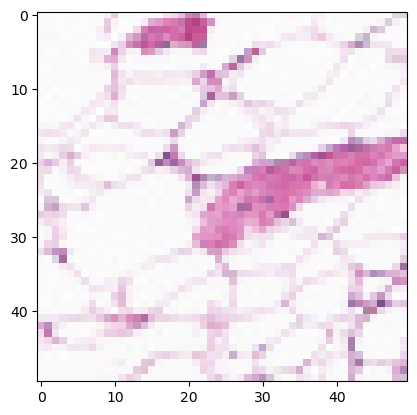

In [53]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


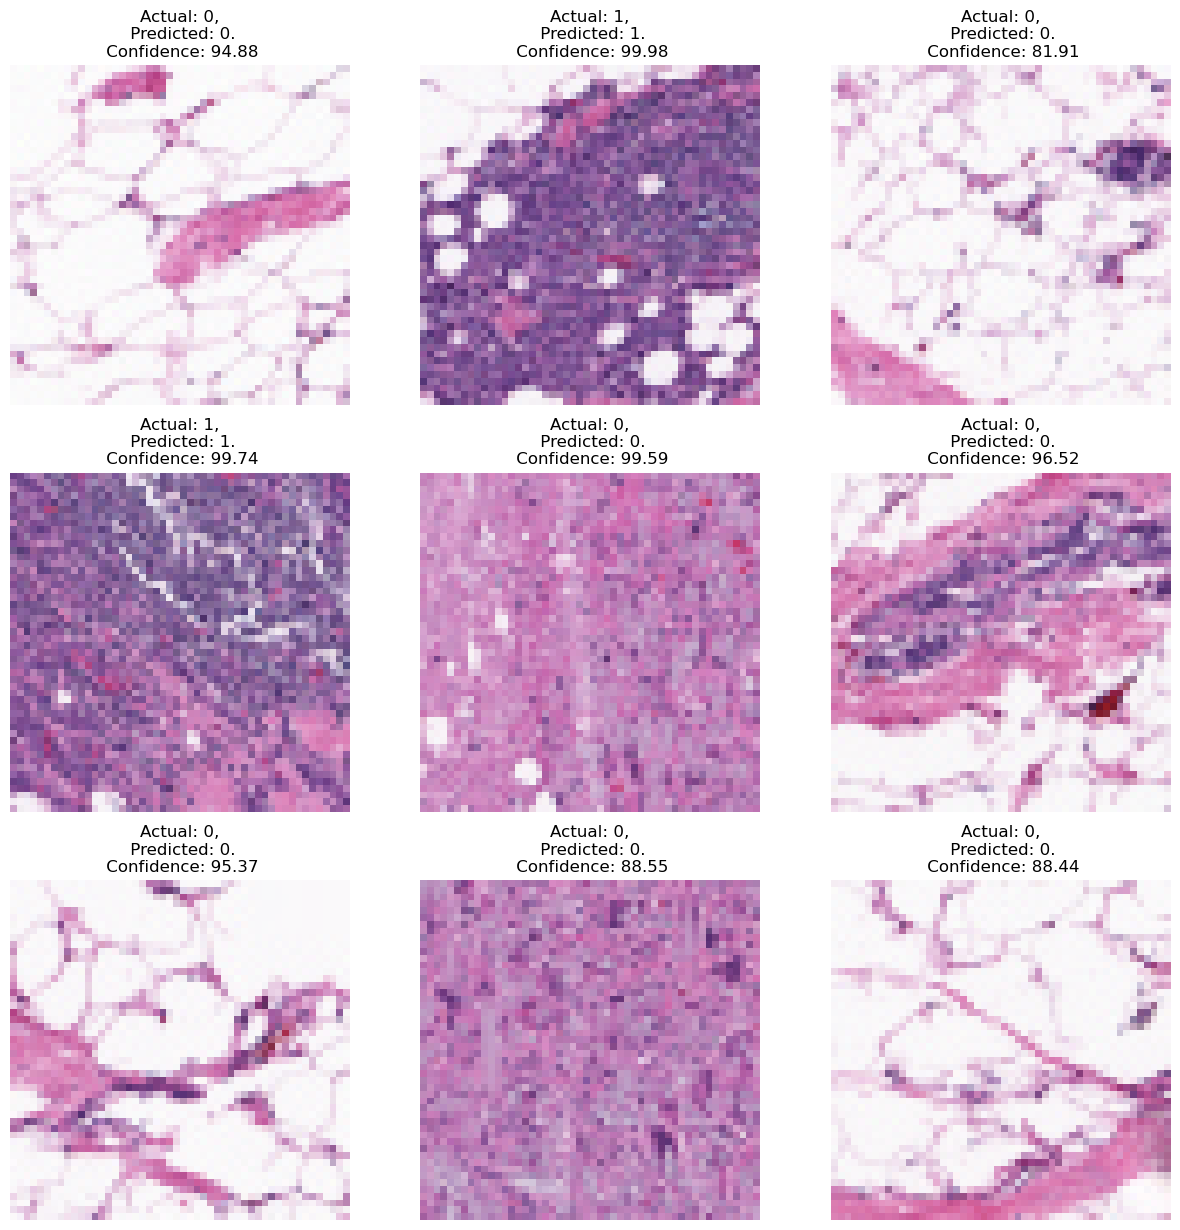

In [55]:
plt.figure(figsize = (15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")
        
        plt.axis('off')

Model_saving

In [ ]:
# Setting up the autoincrement system for model versions

model_version = max([int(i) for i in os.listdir("saved_models") + [0]]) + 1
model_version

2

In [ ]:
# Saving a final model with updated version
model.save(f"saved_models/{model_version}")

INFO:tensorflow:Assets written to: saved_models/2\assets


INFO:tensorflow:Assets written to: saved_models/2\assets


Saving the last model in H5 format so that there is just one file that I can upload to GCP.

In [ ]:
model.save("saved_models/latest_potato_model.h5")

c:\Users\akash\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
